# SIC PROJECT


Import the dependencies and set the device


In [4]:
# requirements and dependencies
# check if the requirements are installed
requirements = [
    "tensorflow",
    "numpy",
    "matplotlib",
    "tensorboard",
    "tensorflow_hub",
    "sklearn",
]
# if not, quit
for requirement in requirements:
    try:
        __import__(requirement)
    except ImportError:
        print("one or more requirements are not installed")
        print("please install the requirements in the requirements.txt file")
        print("you can do this by running the following command in the terminal:")
        print("pip install -r requirements.txt")
        raise ImportError("Requirement not installed: {}".format(requirement))

print("All requirements are installed, you are good to go!")

All requirements are installed, you are good to go!


In [6]:
#import packages
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



%load_ext tensorboard
print("success")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
success


In [8]:
# check devices available
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.config.list_physical_devices()

/device:GPU:0
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Exploring and Processing


- Reading, processing, and augmenting all done by `ImageDataGenerator`


**Rapid EDA**


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
datagen = ImageDataGenerator()
train_ds = datagen.flow_from_directory("data/train")
print("classes: ", train_ds.class_indices)
imgs, labels = train_ds.next()

Found 2295 images belonging to 3 classes.
classes:  {'Fire': 0, 'Neutral': 1, 'Smoke': 2}


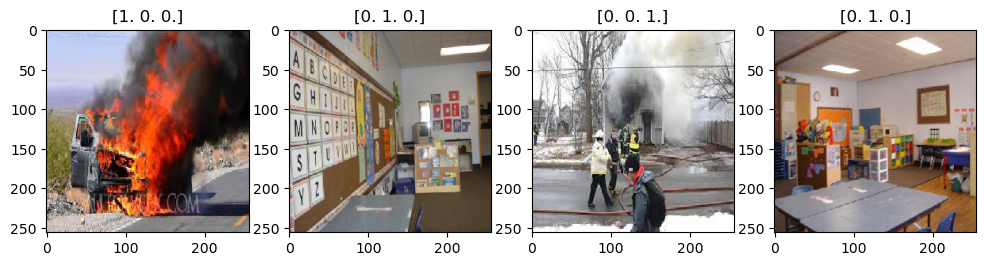

In [13]:
# display random images from the dataset
fig, ax = plt.subplots(1, 4, figsize=(12, 9))
for i in range(4):
    idx = np.random.randint(0, len(imgs))
    ax[i].imshow(imgs[idx].astype("uint8"))
    ax[i].set_title(labels[idx])

**Processing and Augmenting Data**


In [14]:
# only augmenting the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=10.0,
    height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True,
)

test_val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_ds = train_datagen.flow_from_directory("data/train", target_size=(224, 224))
val_ds = test_val_datagen.flow_from_directory("data/val", target_size=(224, 224))
test_ds = test_val_datagen.flow_from_directory("data/test", target_size=(224, 224))

Found 2295 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


# Models building


In [58]:
# built from scratch model
def get_builtFromScartchModel(
    IMG_SIZE=224, NUM_CLASSES=3, dropout_rate=0.2, lr=0.001, act="relu"
):
    """
    A function to build a model from scratch

    Args:
        IMG_SIZE (int, optional): Image size. Defaults to 224.
        NUM_CLASSES (int, optional): Number of classes. Defaults to 3.
        dropout_rate (float, optional): Dropout rate. Defaults to 0.2.
        lr (float, optional): Learning rate. Defaults to 0.001.
        act (str, optional): Activation function for middle layers. Defaults to "relu".

    Returns:
        model: A compiled model built from scratch
    """
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)
            ),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation=act),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Conv2D(32, (3, 3), activation=act),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation=act),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(48, activation=act),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(32, activation=act),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    # get model summary
    model.summary()

    return model

In [17]:
def get_trained_model(url, inputShape=(224, 224, 3), trainModel=True, lr=0.001):
    """
    A function to get a trained model from a url

    Args:
        url (str): url of the model
        inputShape (tuple, optional): input shape of the model. Defaults to (224, 224, 3).
        trainModel (bool, optional): whether to train the model. Defaults to True.
        lr (float, optional): learning rate of the model. Defaults to 0.001.

    Returns:
        model: a trained model
    """
    feature_extractor_layer = hub.KerasLayer(
        url, input_shape=inputShape, trainable=trainModel
    )

    model = tf.keras.Sequential(
        [
            feature_extractor_layer,
            tf.keras.layers.Dense(3, activation="softmax"),  # smoke, normal, fire
        ]
    )

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )

    # display the model summary
    model.summary()

    return model

In [33]:
def evaluate(model, fitHistory, test_data):
    """
    Test the model on the test data and print the accuracy, confusion matrix and classification report.

    Args:
        model: A Keras model.
        fitHistory: A Keras History object returned by the `fit` method.
        test_data: A keras dataset object.

    """
    # convert test_data to numpy array
    y = np.concatenate([test_data.next()[1] for i in range(test_data.__len__())])

    # predict
    predictions = model.predict(test_data)
    predictions = np.argmax(predictions, axis=1)
    test_labels = np.argmax(y, axis=1)
    print("-" * 50)
    # print accuracy
    print(
        "Test Accuracy: "
        + str(accuracy_score(test_labels, predictions))
        + "\n"
        + "-" * 10
        + "\n"
        + "while fitting the model, the accuracy was: \n"
        + str(fitHistory.history["categorical_accuracy"][-1])
        + " in the train data"
        + "\n"
        + str(fitHistory.history["val_categorical_accuracy"][-1])
        + " in the validation data"
    )
    # print confusion matrix
    print("-" * 50)
    print("Confusion matrix:\n" + str(confusion_matrix(test_labels, predictions)))
    print("-" * 50)
    # print classification report
    print(
        "Classification report:\n"
        + str(
            classification_report(
                test_labels, predictions, target_names=["Fire", "Neutral", "Smoke"]
            )
        )
    )

# Train & Hyperparameter tuning


**1.0 Build multiple `FromScratch Model` with different hyperparameters**


In [61]:
# load model
model = get_builtFromScartchModel(act="leaky_relu")

# some parameters
EPOCHS = 10
IMG_SIZE = 224
BATCH_SIZE = 32

# for tensorboard
log_dir = (
    "logs/fit/" + str(len(os.listdir("logs/fit")) + 1)
    if os.path.exists("logs/fit")
    else "logs/fit/1"
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with tf.device("/device:GPU:0"):
    historyFit = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[tensorboard_callback],
    )

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_39 (Dropout)        (None, 54, 54, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 52, 52, 32)      

In [62]:
evaluate(model, historyFit, test_ds)

10/10 [==============================] - 0s 34ms/step
--------------------------------------------------
Test Accuracy: 0.77
----------
while fitting the model, the accuracy was: 
0.8034858107566833 in the train data
0.800000011920929 in the validation data
--------------------------------------------------
Confusion matrix:
[[89  8  3]
 [12 79  9]
 [ 6 31 63]]
--------------------------------------------------
Classification report:
              precision    recall  f1-score   support

        Fire       0.83      0.89      0.86       100
     Neutral       0.67      0.79      0.72       100
       Smoke       0.84      0.63      0.72       100

    accuracy                           0.77       300
   macro avg       0.78      0.77      0.77       300
weighted avg       0.78      0.77      0.77       300



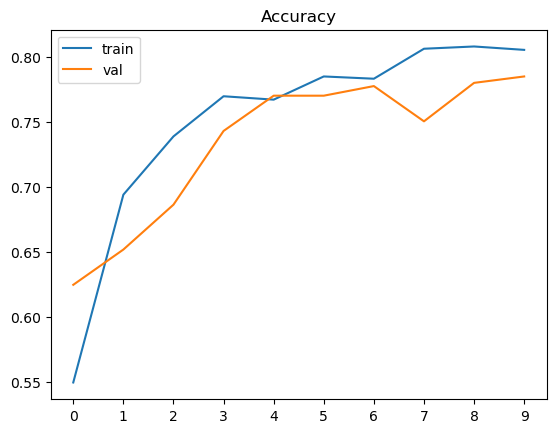

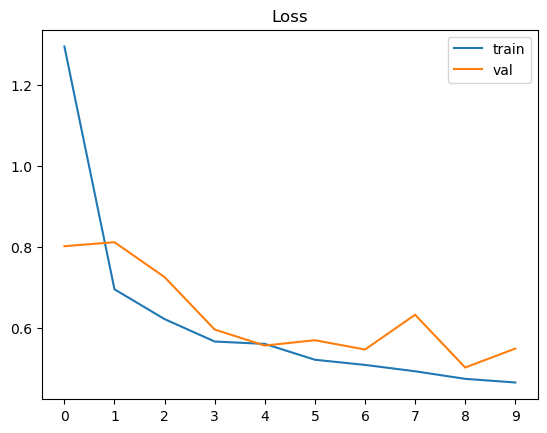

In [ ]:
plt.plot(historyFit.history["categorical_accuracy"], label="train")
plt.plot(historyFit.history["val_categorical_accuracy"], label="val")
plt.xticks(np.arange(10))
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(historyFit.history["loss"], label="train")
plt.plot(historyFit.history["val_loss"], label="val")
plt.xticks(np.arange(10))
plt.title("Loss")
plt.legend()
plt.show()

**1.1 Search for Best Learning rate**


In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = get_builtFromScartchModel(lr=lr)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[lr] = history.history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 54, 54, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 373248)           

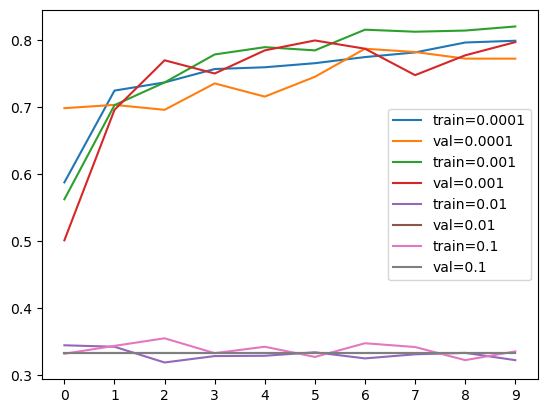

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist["categorical_accuracy"], label=(f"train={lr}"))
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={lr}"))

plt.xticks(np.arange(10))
plt.legend()

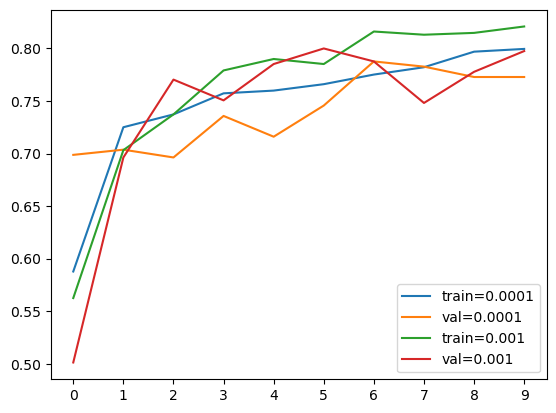

In [ ]:
# remove poor scores to see better
del scores[0.1]
del scores[0.01]

for lr, hist in scores.items():
    plt.plot(hist["categorical_accuracy"], label=(f"train={lr}"))
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={lr}"))

plt.xticks(np.arange(10))
plt.legend()

**1.2 Search for best dropout rate**


In [ ]:
learning_rate = 0.001  # best lr so far
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    model = get_builtFromScartchModel(lr=learning_rate, dropout_rate=droprate)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[droprate] = history.history

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 111, 111, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 54, 54, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 54, 54, 128)       0         
                                                                 
 flatten_7 (Flatten)         (None, 373248)           

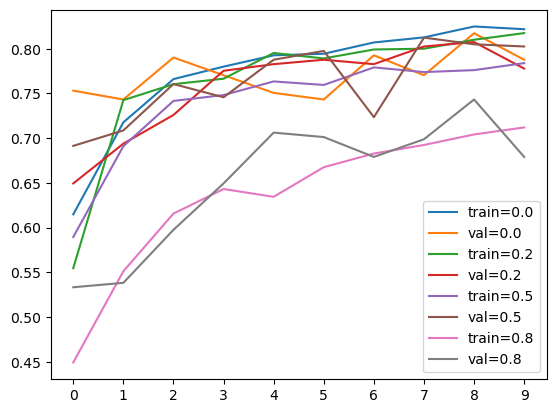

In [ ]:
for droprate, hist in scores.items():
    plt.plot(hist["categorical_accuracy"], label=(f"train={droprate}"))
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={droprate}"))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
# del scores[0.8] #poor performance

colors = ["red", "blue", "green"]

for i, (droprate, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={droprate}"), color=colors[i])
    plt.plot(
        hist["val_categorical_accuracy"],
        linestyle="dashed",
        label=(f"val={droprate}"),
        color=colors[i],
    )

plt.xticks(np.arange(10))
plt.legend()
plt.show()

**_Best Hyperparameters so far:_**

- learning_rate = 0.001
- droprate = 0.2 (I might try 0.1 later)


**2.0 Build multiple `Pre-trained Model (EfficientNetv2)` with different hyperparameters**


> Not Done yet


In [70]:
# Load the EfficientNetV2 pre-trained model from TensorFlow Hub, recommended input size is 240x240 pixels
module_url = (
    "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2"
)
model = get_trained_model(module_url)

# for tensorboard
log_dir = (
    "logs/fit/" + str(len(os.listdir("logs/eval")) + 1)
    if os.path.exists("logs/eval")
    else "logs/eval/1"
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# some parameters
EPOCHS = 15
BATCH_SIZE = 32

with tf.device("/device:GPU:0"):
    historyFit = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[tensorboard_callback],
        batch_size=BATCH_SIZE,
    )

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1000)              8212124   
                                                                 
 dense_52 (Dense)            (None, 3)                 3003      
                                                                 
Total params: 8215127 (31.34 MB)
Trainable params: 8144055 (31.07 MB)
Non-trainable params: 71072 (277.62 KB)
_________________________________________________________________
Epoch 1/15
72/72 [==============================] - 94s 982ms/step - loss: 0.4859 - categorical_accuracy: 0.8606 - val_loss: 0.1781 - val_categorical_accuracy: 0.9556
Epoch 2/15
72/72 [==============================] - 31s 418ms/step - loss: 0.2721 - categorical_accuracy: 0.9137 - val_loss: 0.2880 - val_categorical_accuracy: 0.9259
Epoch 3/15
72/72 [==============================] - 29s 384ms/step - lo

In [71]:
evaluate(model, historyFit, test_ds)
# ask the user if he wants to save the model
save = input("Do you want to save the model? (y/n)")
if save == "y":
    model.save("Models/preTrainedModel.h5")
    print("Model saved")
else:
    print("Model not saved")

10/10 [==============================] - 10s 576ms/step
--------------------------------------------------
Test Accuracy: 0.9566666666666667
----------
while fitting the model, the accuracy was: 
0.9694989323616028 in the train data
0.9679012298583984 in the validation data
--------------------------------------------------
Confusion matrix:
[[93  1  6]
 [ 2 98  0]
 [ 2  2 96]]
--------------------------------------------------
Classification report:
              precision    recall  f1-score   support

        Fire       0.96      0.93      0.94       100
     Neutral       0.97      0.98      0.98       100
       Smoke       0.94      0.96      0.95       100

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



/Users/mohammed/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved


In [ ]:
#lunch tensorboard to plot the results and the graphs
%tensorboard --logdir logs --port=6910